In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from scipy import stats

def load_data(file):
   
    print('loading file: ' + file)
    with open(file, 'rb') as f:
        data = pickle.load(f)

    return(data)

def upper(df):
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

def average_across_points(dat, window_size=10):
    dshape = dat['eeg'].shape
    
    new_length = dshape[-1] // window_size
    eeg_reshaped = dat['eeg'][:, :, :new_length * window_size].reshape(dshape[0], dshape[1], new_length, window_size)
    dat['eeg'] = eeg_reshaped.mean(axis=-1)
    dat['time'] = dat['time'][:new_length * window_size].reshape(new_length, window_size).mean(axis=-1)
    
    return dat

### Get model RDMS 
model_vis = load_data("/projects/crunchie/boyanova/EEG_Things/eeg_experiment/model_activations/alexnet/standardized_maps.pickle")["conv1"]
model_txt = load_data("/projects/crunchie/boyanova/EEG_Things/eeg_experiment/model_activations/alexnet/standardized_maps.pickle")["fc8"]

#model_vis = load_data()[""]
#model_txt = load_data()[""]

clip_rdms = [1 - np.corrcoef(model_vis), 
            1 - np.corrcoef(model_txt)]

### Get human RDMs for eeg
sub = 1
eeg_data = load_data(f"/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_{sub:04d}_fix.pickle")
eeg_data = average_across_points(eeg_data, window_size=10)
time = eeg_data['time']

#eeg_rdms = load_data(f"/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_{sub:04d}.pickle")

# =============================================================================
# Correlartion Based EEG
# =============================================================================

#eeg_rdms = load_data(f"/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_rsa/eeg_rdms_{sub:04d}.pickle")

# =============================================================================
# EDI Based EEG
# =============================================================================
# eeg_rdms =  load_data(f"/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_{sub:04d}.pickle")
# eeg_norm_edi = {}
# for key_id, key in enumerate(eeg_rdms.keys()):
#     eeg_norm_edi[key] = np.full((4,4,len(time)), np.nan)
#     for t in range(len(time)):
#         mahalanobis_matrix = eeg_rdms[key][:, :, t] 

#         # Loop over each unique pair (i, j) where i < j
#         for i in range(4):
#             for j in range(i + 1, 4):
                
#                 # Extract the distance between items i and j
#                 pair_distance = mahalanobis_matrix[i, j]
#                 # Calculate the mean of the diagonal values for items i and j
#                 mean_diagonal = np.mean([mahalanobis_matrix[i, i], mahalanobis_matrix[j, j]])
#                 # Compute the normalized distance and store it
#                  eeg_norm_edi[key][i, j, t] = pair_distance - mean_diagonal
        
# =============================================================================
# SVM based EEG
# =============================================================================
eeg_rdms = load_data(f"/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_{sub:04d}.pickle")
    

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/model_activations/alexnet/standardized_maps.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/model_activations/alexnet/standardized_maps.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0001_fix.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_0001.pickle


In [2]:
eeg_norm_edi[key][:, :, 0]

NameError: name 'eeg_norm_edi' is not defined

In [65]:
# Assuming edi_data[key][:, :, t] is a 4x4 Mahalanobis distance matrix
# Replace edi_data[key][:, :, t] with your actual matrix if different
eeg_norm_edi = {}
for key_id, key in enumerate(eeg_rdms.keys()):
    eeg_norm_edi[key] = np.full((4,4,len(time)), np.nan)
    for t in range(len(time)):
        mahalanobis_matrix = eeg_rdms[key][:, :, t] 

        # Loop over each unique pair (i, j) where i < j
        for i in range(4):
            for j in range(i + 1, 4):
                
                # Extract the distance between items i and j
                pair_distance = mahalanobis_matrix[i, j]
                # Calculate the mean of the diagonal values for items i and j
                mean_diagonal = np.mean([mahalanobis_matrix[i, i], mahalanobis_matrix[j, j]])
                # Compute the normalized distance and store it
                 eeg_norm_edi[key][i, j, t] = pair_distance - mean_diagonal
        

In [5]:
get_spearmans = np.full((4,2,len(time)), np.nan)
for cond_id, cond in enumerate(eeg_rdms.keys()):
    for rdm_id, rdm in enumerate(clip_rdms):
        for t in range(len(time)):
            get_spearmans[cond_id, rdm_id, t] = stats.spearmanr(upper(eeg_rdms[cond][:, :, t]), upper(rdm))[0]

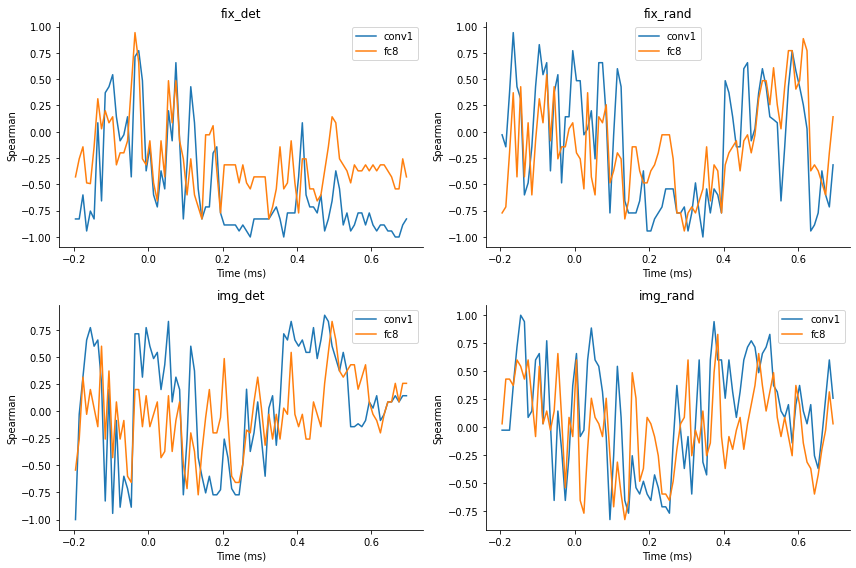

In [6]:
import matplotlib.pyplot as plt

# Set up a 2x2 grid for 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()  # Flatten axes array for easy iteration

# Iterate through each subplot
for x in range(4):
    ax = axes[x]
    ax.plot(time, get_spearmans[x, 0, :], label="conv1")
    ax.plot(time, get_spearmans[x, 1, :], label="fc8")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Spearman")
    ax.set_title(list(eeg_rdms.keys())[x])
    
    # Hide upper and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Display legend
    ax.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [36]:
# Define subjects to iterate through
subjects = [0, 1]

# Create a dictionary to store Spearman results for each subject
spearman_results = {}

for sub in subjects:
    # Load CLIP model RDMs
    clip_data = load_data("/projects/crunchie/boyanova/EEG_Things/eeg_prep/scripts/exp_stimuli_selection.pkl")
    clip_vis = clip_data["image_embeddings"]
    clip_txt = clip_data["text_embeddings"]
    
    # Load human EEG RDMs and EEG data for each subject
    eeg_rdms = load_data(f"/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_{sub:04d}.pickle")
    eeg_data = load_data(f"/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_{sub:04d}_fix.pickle")
    eeg_data = average_across_points(eeg_data, window_size=10)
    time = eeg_data['time']
    
    # Precompute the CLIP model RDMs
    clip_rdms = [
        1 - np.corrcoef(clip_vis),  # Visual RDM
        1 - np.corrcoef(clip_txt)   # Text RDM
    ]
    
    # Initialize array to store Spearman correlations
    get_spearmans = np.full((4, 2, len(time)), np.nan)  # Shape: (conditions, model RDMs, time points)
    
    # Compute Spearman's correlations in a time-resolved manner
    for cond_id, cond in enumerate(eeg_rdms.keys()):
        for rdm_id, rdm in enumerate(clip_rdms):
            for t in range(len(time)):
                # Calculate the Spearman correlation
                eeg_rdm_upper = upper(eeg_rdms[cond][:, :, t])
                model_rdm_upper = upper(rdm)
                
                # Use `spearmanr` to compute the correlation
                spearman_corr= np.corrcoef(eeg_rdm_upper, model_rdm_upper)[0,1]
                get_spearmans[cond_id, rdm_id, t] = spearman_corr
    
    # Store the results for each subject
    spearman_results[f"sub_{sub}"] = get_spearmans

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_prep/scripts/exp_stimuli_selection.pkl
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0000.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0000_fix.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_prep/scripts/exp_stimuli_selection.pkl
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0001.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0001_fix.pickle


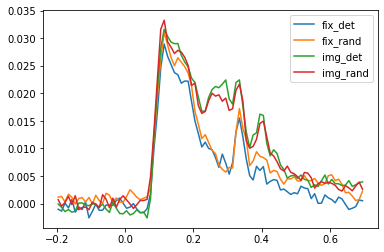

In [55]:
for key in eeg_rdms.keys():
    vec=[]
    for t in range(eeg_rdms[key].shape[-1]):
        vec.append(np.mean(upper(eeg_norm_edi[key][:, :, t])))
    plt.plot(time, vec, label = key)
        
plt.legend()

In [15]:
subjects = [0,1]
subject_data_svm = np.full((len(subjects), 4, 4, 4, len(time)), np.nan)
for sub in subjects:
    data = load_data(f"/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_{sub:04d}.pickle")
    for k_id, k in enumerate(data.keys()):
        for t in range(len(time)):
            subject_data_svm[sub, k_id, :, :, t] = data[k][:,:,t]
        
    

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_0000.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_0001.pickle


In [27]:
get_subject_correlation = np.full((4, len(time)), np.nan)
get_subject_spearman = np.full((4, len(time)), np.nan)

for cond in range(4):
    for x in range(len(time)):
        get_subject_correlation[cond, x] = np.corrcoef(upper(subject_data_svm[1, cond, :, :, x]),
                                                      upper(subject_data_svm[0, cond, :, :, x]))[0,1]
        
        get_subject_spearman[cond, x] = stats.spearmanr(upper(subject_data_svm[1,  cond, :, :, x]),
                                                       upper(subject_data_svm[0,  cond, :, :, x]))[0]

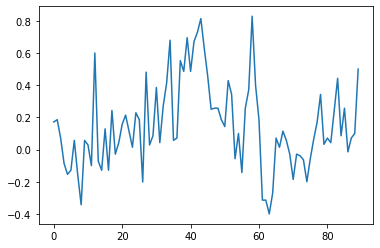

In [29]:
plt.plot(np.mean(get_subject_spearman, axis=0))

In [ ]:
np.a

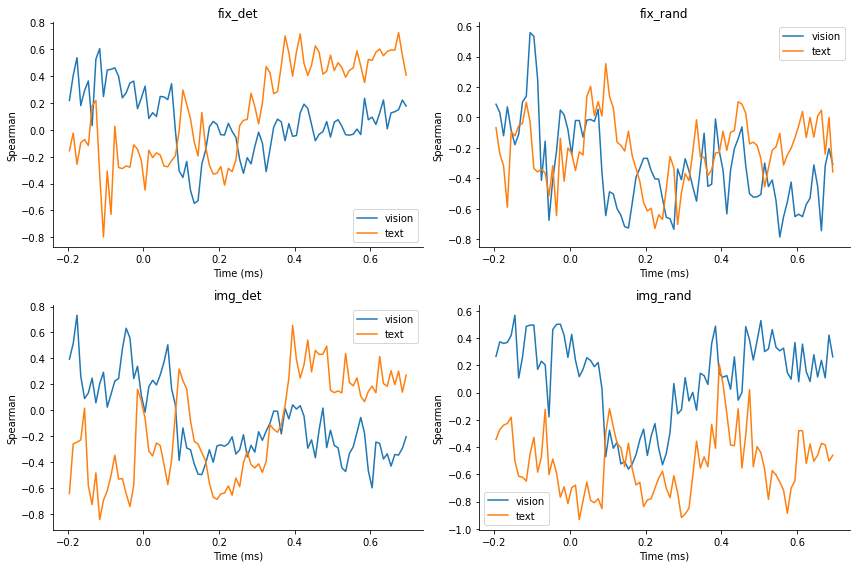

In [37]:
# Assuming time, eeg_rdms keys, and spearman_results have been defined with appropriate data
# Calculate the average between the two participants
get_spearmans_avg = (spearman_results["sub_0"] + spearman_results["sub_1"]) / 2

# Set up a 2x2 grid for 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()  # Flatten axes array for easy iteration

# Iterate through each subplot
for x in range(4):
    ax = axes[x]
    ax.plot(time, get_spearmans_avg[x, 0, :], label="vision")
    ax.plot(time, get_spearmans_avg[x, 1, :], label="text")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Spearman")
    ax.set_title(list(eeg_rdms.keys())[x])
    
    # Hide upper and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Display legend
    ax.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [48]:
main_folder = "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/"
subjects = [0,1]
subject_data = np.full((len(subjects), 4, 4, 4, len(time)), np.nan)

for sub_id, sub in enumerate(subjects):
    edi_data = load_data(os.path.join(main_folder, f"eeg_decoding/eeg_mahlanobis_{sub:04d}.pickle"))
    for key_id, key in enumerate(edi_data.keys()):
        for t in range(edi_data[key].shape[-1]):
            subject_data[sub_id, key_id, :, :, t] = np.nansum([subject_data[sub_id, key_id, :, :, t], edi_data[key][:, :, t]], axis=0)

# Step 1: Compute the mean and standard deviation across subjects (axis=0)
mean_data = np.mean(subject_data, axis=0)

eeg_norm_edi = {}
for key_id, key in enumerate(eeg_rdms.keys()):
    eeg_norm_edi[key] = np.full((4,4,len(time)), np.nan)
    for t in range(len(time)):
        mahalanobis_matrix = mean_data[key_id, :, :, t] 

        # Loop over each unique pair (i, j) where i < j
        for i in range(4):
            for j in range(i + 1, 4):
                
                # Extract the distance between items i and j
                pair_distance = mahalanobis_matrix[i, j]
                # Calculate the mean of the diagonal values for items i and j
                mean_diagonal = np.mean([mahalanobis_matrix[i, i], mahalanobis_matrix[j, j]])
                # Compute the normalized distance and store it
                eeg_norm_edi[key][i, j, t] = pair_distance - mean_diagonal

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0000.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0001.pickle
